# Christmas crossword puzzle

## Read the board

I prepared this image by taking a picture with CamScanner (Android ap), then cropped with IrfanView.

In [1]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

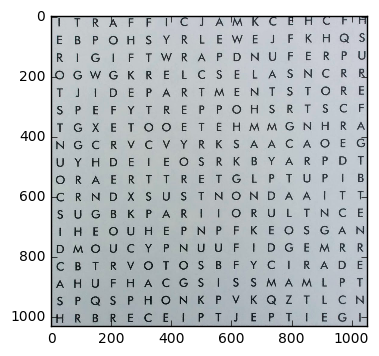

In [2]:
img_file = 'board.jpg'
img = cv2.imread(img_file)
plt.imshow(img)

Let's try Tesseract, a free OCR program to read letters.

In [3]:
import string
alphabets = string.ascii_uppercase

Tesseract typically works fine once you specify characters, and set the page segmentation mode.

`-psm 6` option means "Assume a single uniform block of text".

In [4]:
!tesseract $img_file output -c tessedit_char_whitelist=$alphabets -psm 6

Tesseract Open Source OCR Engine v3.04.01 with Leptonica


In [5]:
with open('output.txt', 'r') as f:
    data = f.readlines()
board = [s.strip() for s in data if s.strip()]
board

['ITRAFFICJAMKCEHCFH',
 'EBPOHSYRLEWEJFKHQS',
 'RIGIFTWRAPDNUFERPU',
 'OGWGKRELCSELASNCRR',
 'TJIDEPARTMENTSTORE',
 'SPEFYTREPPOHSRTSCF',
 'TGXETOOETEHMMGNHRA',
 'NGCRVCVYRKSAACAOEG',
 'UYHDEIEOSRKBYARPDT',
 'ORAERTTRETGLPTUPIB',
 'CRNDXSUSTNONDAAITT',
 'SUGBKPARIIORULTNCE',
 'IHEOUHEPNPFKEOSGAN',
 'DMOUCYPNUUFIDGEMRR',
 'CBTRVOTOSBFYCIRADE',
 'AHUFHACGSISSMAMLPT',
 'SPQSPHONKPVKQZTLCN',
 'HRBRECEIPWWEGI']

Hmmm, it appears OK EXCEPT for the last line... Replace the last with a manual entry.

In [6]:
board[-1] = 'HRBRECEIPTJEPTIEGI'
board

['ITRAFFICJAMKCEHCFH',
 'EBPOHSYRLEWEJFKHQS',
 'RIGIFTWRAPDNUFERPU',
 'OGWGKRELCSELASNCRR',
 'TJIDEPARTMENTSTORE',
 'SPEFYTREPPOHSRTSCF',
 'TGXETOOETEHMMGNHRA',
 'NGCRVCVYRKSAACAOEG',
 'UYHDEIEOSRKBYARPDT',
 'ORAERTTRETGLPTUPIB',
 'CRNDXSUSTNONDAAITT',
 'SUGBKPARIIORULTNCE',
 'IHEOUHEPNPFKEOSGAN',
 'DMOUCYPNUUFIDGEMRR',
 'CBTRVOTOSBFYCIRADE',
 'AHUFHACGSISSMAMLPT',
 'SPQSPHONKPVKQZTLCN',
 'HRBRECEIPTJEPTIEGI']

Now we are ready.

## Keywords

Remove space from keywords and make them uppercase, after entering 30 keywords (manually!)

In [7]:
keywords = ['bookstore', 'buy', 'cash', 'catalog', 'check', 'coupon', 'credit card',
            'department store', 'discount store', 'drive', 'exchange', 'expensive',
            'gift certificate', 'gift wrap', 'honk', 'hurry', 'internet', 'jewelry shop',
            'purchase', 'receipt', 'refund', 'restaurant', 'return', 'rush',
            'salesclerk', 'shopper', 'shopping bag', 'shopping mall', 'toy store',
            'traffic jam']

keywords = [k.replace(' ', '').upper() for k in keywords]
len(keywords)

30

In [8]:
keywords

['BOOKSTORE',
 'BUY',
 'CASH',
 'CATALOG',
 'CHECK',
 'COUPON',
 'CREDITCARD',
 'DEPARTMENTSTORE',
 'DISCOUNTSTORE',
 'DRIVE',
 'EXCHANGE',
 'EXPENSIVE',
 'GIFTCERTIFICATE',
 'GIFTWRAP',
 'HONK',
 'HURRY',
 'INTERNET',
 'JEWELRYSHOP',
 'PURCHASE',
 'RECEIPT',
 'REFUND',
 'RESTAURANT',
 'RETURN',
 'RUSH',
 'SALESCLERK',
 'SHOPPER',
 'SHOPPINGBAG',
 'SHOPPINGMALL',
 'TOYSTORE',
 'TRAFFICJAM']

## Search for words

I want to know a sequence of coordinate positions when a word is found. So, for bookkeeping purpose, I introduce "state" which has tuples (letter, coordinate) as grid elements. Haskell's type notation would clarify what I mean:

```haskell
Coordinate = (Int, Int)
State :: [[(Char, Coordinate)]]
Board :: [String]
Coordinates :: [[Coordinate]]
```


In [9]:
def to_state(board):
    state = [[(c, (row, col)) for (col, c) in enumerate(line, 1)] 
             for (row, line) in enumerate(board, 1)]
    return state

In [10]:
def to_board(state):
    return [''.join(c for (c, _) in lines) for lines in state]

In [11]:
def to_coordinates(state):
    return [[tup for (_, tup) in lines] for lines in state]

For a given state, I only search for a word from left to right, and line by line. I'll handle other directions by transforming the state, as you'll see later.

In [12]:
def find(state, word):
    board = to_board(state)
    coordinates = to_coordinates(state)
    found = []
    for (pairs, line) in zip(coordinates, board):
        if word in line:
            idx = line.index(word)
            size = len(word)
            found = pairs[idx:idx+size]
            break
    return found

They are helper functions manipulating a grid. Lo and behold, they are concise and no array indexing is used.  This is a functional programming style.

In [13]:
import itertools as it

def reverse_list(lst):
    """
    >>> reverse_list([1, 2, 3])
    [3, 2, 1]
    """
    return list(reversed(lst))

def rev(state):
    """
    >>> xs = [[1, 2], [3, 4]]
    >>> rev(xs)
    [[2, 1], [4, 3]]
    """
    return [reverse_list(line) for line in state]

def identity(state):
    return state

def transpose(state):
    """
    >>> xs = [[1, 2], [3, 4]]
    >>> transpose(xs)
    [[1, 3], [2, 4]]
    """
    return [list(tup) for tup in zip(*state)]

def diagonal(state):
    """
    >>> xs = [[1, 2], [3, 4]]
    >>> diagonal(xs)
    [[1], [2, 3], [4]]
    """
    iterable = it.zip_longest(*[[None]*i + list(line) for (i, line) in enumerate(state)])
    res = [[tup for tup in line if tup is not None] 
           for line in iterable]
    return res

def antidiagonal(state):
    """
    >>> xs = [[1, 2], [3, 4]]
    >>> antidiagonal(xs)
    [[3], [1, 4], [2]]
    """
    return reverse_list(diagonal(rev(state)))

## Unit test!

In [14]:
import doctest
doctest.testmod()

TestResults(failed=0, attempted=9)

## Solution
This is the main algorithm. Self explanatory?

In [15]:
def solve(board, keywords):
    state = to_state(board)
    states = [g(f(state)) 
              for g in [identity, rev] 
              for f in [identity, transpose, diagonal, antidiagonal]]

    res = []
    for s in states:
        for w in keywords:
            coordinates = find(s, w)
            if coordinates:
                pair = (w, coordinates)
                res.append(pair)
    return res

The solution is fast enough, of course.

In [16]:
%timeit solve(board, keywords)

100 loops, best of 3: 14.4 ms per loop


In [17]:
res = solve(board, keywords)
for (kwd, coords) in res:
    print(kwd, ': ', coords, sep='')

DEPARTMENTSTORE: [(5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18)]
GIFTWRAP: [(3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10)]
HONK: [(17, 6), (17, 7), (17, 8), (17, 9)]
RECEIPT: [(18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10)]
TRAFFICJAM: [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11)]
CASH: [(15, 1), (16, 1), (17, 1), (18, 1)]
CATALOG: [(8, 14), (9, 14), (10, 14), (11, 14), (12, 14), (13, 14), (14, 14)]
CREDITCARD: [(6, 17), (7, 17), (8, 17), (9, 17), (10, 17), (11, 17), (12, 17), (13, 17), (14, 17), (15, 17)]
EXCHANGE: [(6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3)]
SHOPPINGMALL: [(6, 16), (7, 16), (8, 16), (9, 16), (10, 16), (11, 16), (12, 16), (13, 16), (14, 16), (15, 16), (16, 16), (17, 16)]
BUY: [(12, 4), (13, 5), (14, 6)]
EXPENSIVE: [(10, 4), (11, 5), (12, 6), (13, 7), (14, 8), (15, 9), (16, 10), (17, 11), (18, 1

Anything missing? --- None.  (My initil attmept missed one word because of a typo in keywords!)

In [18]:
found = {word for (word, _) in res}
missing = set(keywords) - found
print(missing)

set()


## Show the answer

Matplotlib is most frequently used library for 2-D visualization. But just give Bokeh a try this time.

In [19]:
from bokeh.io import output_notebook, reset_output
from bokeh.plotting import figure, show
reset_output()
output_notebook()

Loading BokehJS ...

In [20]:
p = figure(title='Crossword Result', x_axis_location='above')
p.plot_width = 500
p.plot_height = 500
p.toolbar_location = None
p.xaxis.visible = False
p.yaxis.visible = False

In [21]:
xs, ys, letters = [], [], []
for line in to_state(board):
    for (letter, (i, j)) in line:
        xs.append(j)
        ys.append(-i)
        letters.append(letter)

p.text(xs, ys, text=letters, 
       text_align='center',
       text_baseline='middle')

GlyphRenderer(id='191259bd-e420-487b-98ff-87cee4449c58', ...)

In [22]:
for (word, pairs) in res:
    row_ini, col_ini = pairs[0]
    row_fin, col_fin = pairs[-1]
    p.line(x=[col_ini, col_fin], 
           y=[-row_ini, -row_fin],
           line_width=8,
           alpha=0.4,
           name=word)

In [23]:
show(p)